In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv(r'C:\Users\abc\Data Science and ML\CampusX\Project\self\project_4.csv')

In [3]:
df.sample(5)

,property_type,society,sector,price_in_lacs,price_per_sqft_inrs,builtup,bedRoom,bathroom,balcony,floorNum,agePossession,furnish_type,servant_room,study room,pooja room,store_room,others,luxury_score
946,flat,la vida by tata housing,sector 113,165.0,10449.0,1420.0,3,2,2,3.0,Relatively New,0.0,0,0,0,0,0,61.0
2322,flat,pyramid urban homes 2,sector 86,50.0,9698.0,572.0,2,2,2,6.0,Old Property,0.0,0,0,0,0,0,14.0
2417,flat,corona gracieux,sector 76,146.0,5500.0,2398.0,4,6,3+,8.0,New Property,0.0,1,0,0,0,0,0.0
3168,house,madan puri,sector 7,75.0,12500.0,600.0,3,5,3,3.0,Moderately Old,0.0,0,0,0,0,0,0.0
3012,house,bptp visionnaire,sector 70a,402.0,7309.0,5500.0,4,4,3+,3.0,Relatively New,0.0,1,1,1,1,0,0.0


In [4]:
df['furnish_type'].value_counts()

furnish_type
0.0    2393
2.0    1000
1.0     211
Name: count, dtype: int64

In [5]:
df['furnish_type'].replace({0.0 : 'unfurnished',1.0 : 'semifurnished',2.0 : 'fullfurnished'},inplace=True)

C:\Users\abc\AppData\Local\Temp\ipykernel_10516\3269588625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['furnish_type'].replace({0.0 : 'unfurnished',1.0 : 'semifurnished',2.0 : 'fullfurnished'},inplace=True)


In [6]:
df['furnish_type'].value_counts()

furnish_type
unfurnished      2393
fullfurnished    1000
semifurnished     211
Name: count, dtype: int64

<Axes: xlabel='price_in_lacs', ylabel='Count'>

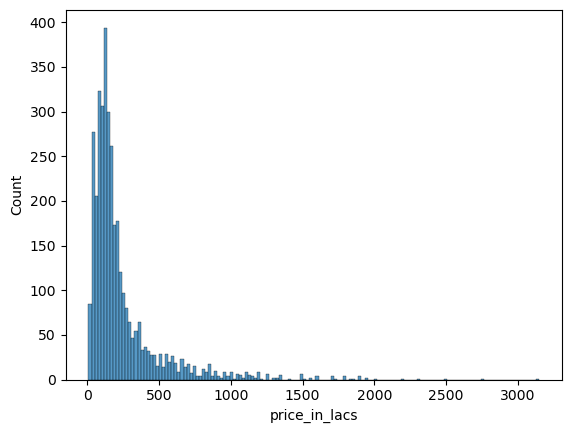

In [7]:
sns.histplot(x=df['price_in_lacs'])

In [8]:
y_trans=np.log1p(df['price_in_lacs'])

<Axes: xlabel='price_in_lacs', ylabel='Count'>

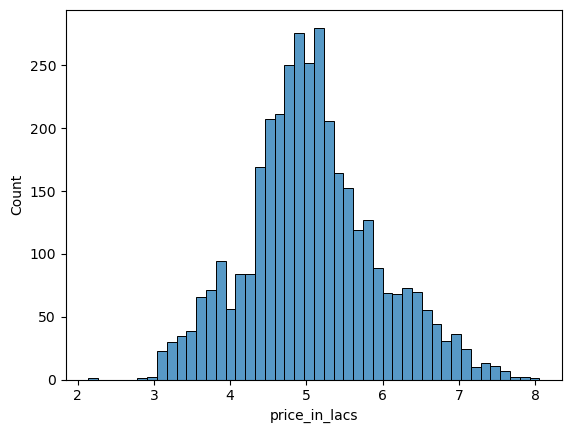

In [9]:
sns.histplot(x=y_trans)

In [10]:
def floor(row):
    if row>=0 and row<=2:
        return 'low rise'
    elif row>=3 and row<=10:
        return 'mid rise'
    elif row>10:
        return 'high rise'
    else:
        return None

df['floorNum_category']=df['floorNum'].apply(floor)

In [11]:
def luxury(score):
    if score>=0 and score <=50:
        return 'low'
    elif score>50 and score <=150:
        return 'medium'
    elif score>150:
        return 'high'
    else:
        return None

df['luxury_score_category']=df['luxury_score'].apply(luxury)

In [12]:
df['sector']=df['sector'].str.strip().str.lower()

In [13]:
df.drop(columns=['pooja room','study room','others','society','price_per_sqft_inrs','floorNum','luxury_score'],inplace=True)


In [14]:
X=df.drop(columns=['price_in_lacs'])
y=df['price_in_lacs']

In [15]:
cat_col=['property_type','sector','balcony','agePossession','floorNum_category','furnish_type','luxury_score_category']
num_col=['builtup','bedRoom','bathroom','servant_room','store_room']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
transform=ColumnTransformer(
    [
        ('cat',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_col),
        ('num',StandardScaler(),num_col)
    ],remainder='passthrough'
)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipe=Pipeline(
    [
        ('preprocessor',transform),
        ('regressor',LinearRegression())
    ]
)

In [18]:
from sklearn.model_selection import cross_val_score,KFold
kfold=KFold(n_splits=5,shuffle=True,random_state=53)
score=cross_val_score(pipe,X,y_trans,cv=kfold,n_jobs=-1,verbose=2,error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


In [19]:
score.mean(),score.std()

(0.7073541395911084, 0.018984640100712945)

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_trans,test_size=0.2,random_state=42)

In [21]:
pipe.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
y_prd=pipe.predict(X_test)
y_prd = np.expm1(y_prd)

In [23]:
from sklearn.metrics import r2_score,mean_squared_error
r2_score(np.expm1(y_test),y_prd),mean_squared_error(np.expm1(y_test),y_prd)

(0.18857017466851678, 74909.9250477506)

In [24]:
np.expm1(y_test)

3027     35.0
1003    500.0
2029    170.0
3141    107.0
1450    262.0
        ...  
176      36.0
1108     90.0
422     180.0
680     248.0
2930    340.0
Name: price_in_lacs, Length: 721, dtype: float64

In [25]:
#pip install xgboost

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [27]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', transform),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_trans, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_trans,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output

In [28]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [29]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

C:\Users\abc\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\abc\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
model_output

[['linear_reg', 0.707158879639454, 104.08289110272597],
 ['svr', 0.7348896973734249, 88.42191733557144],
 ['ridge', 0.7071631243883789, 104.08400646381338],
 ['LASSO', 0.05986978399949653, 155.20539876792685],
 ['decision tree', 0.7962595783614952, 68.02295663135318],
 ['random forest', 0.8919869272283221, 53.204460406340154],
 ['extra trees', 0.8776557957925183, 58.26431306319736],
 ['gradient boosting', 0.8786037753391371, 58.34277230537314],
 ['adaboost', 0.7424767409263193, 88.55139241501827],
 ['mlp', 0.7781101160036158, 84.07839568442078],
 ['xgboost', 0.898557093207119, 50.40932108663487]]

In [31]:
pd.DataFrame(model_output,columns=['algo','r2_score','mae']).sort_values(by='r2_score',ascending=False)

,algo,r2_score,mae
10,xgboost,0.898557,50.409321
5,random forest,0.891987,53.204460
7,gradient boosting,0.878604,58.342772
6,extra trees,0.877656,58.264313
4,decision tree,0.796260,68.022957
9,mlp,0.778110,84.078396
8,adaboost,0.742477,88.551392
1,svr,0.734890,88.421917
2,ridge,0.707163,104.084006
0,linear_reg,0.707159,104.082891


In [32]:
# best model till now :
# xgboost	0.898557	50.409321

# With One Hot Encoding

In [33]:
df.columns

Index(['property_type', 'sector', 'price_in_lacs', 'builtup', 'bedRoom',
       'bathroom', 'balcony', 'agePossession', 'furnish_type', 'servant_room',
       'store_room', 'floorNum_category', 'luxury_score_category'],
      dtype='object')

In [34]:
col_to_ohe=['property_type','sector','agePossession']
col_to_scale=['builtup','bedRoom','bathroom']
col_to_oe=['balcony','furnish_type','servant_room','store_room','luxury_score_category','floorNum_category']

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
transformer=ColumnTransformer(
    [
        ('stand_scale',StandardScaler(),col_to_scale),
        ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore'),col_to_ohe),
        ('oe',OrdinalEncoder(),col_to_oe)
    ],remainder='passthrough'
)

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
from sklearn.pipeline import Pipeline
pipe=Pipeline(
    [
        ('preprocessor',transformer),
        ('model',LinearRegression())
    ]
)

In [38]:
from sklearn.model_selection import KFold,cross_val_score
kfold=KFold(n_splits=5,shuffle=True,random_state=42)
score=cross_val_score(pipe,X,y_trans,scoring='r2',n_jobs=-1,verbose=2,error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [39]:
score.mean(),score.std()

(0.7447758463782345, 0.12374128365006426)

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_trans,test_size=0.2,random_state=42)

In [41]:
pipe.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('stand_scale', ...), ('ohe', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
y_prd=pipe.predict(X_test)
y_prd=np.expm1(y_prd)

In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mae=mean_squared_error(np.expm1(y_test),y_prd)
mae

45281.98845603639

In [44]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [45]:
model_dict={
    'Linear Regression':LinearRegression(),
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest':RandomForestRegressor(),
    'XGBoost':XGBRegressor(),
    'SVR':SVR(),
    'Extra Tree':ExtraTreesRegressor(),
    'Gradient Boosting':GradientBoostingRegressor(),
    'Ada Boost':AdaBoostRegressor(),
    'MLP':MLPRegressor(),
}

In [46]:

def algo(model_name,model):
    output=[]
    output.append(model_name)

    transformer=ColumnTransformer(
        [
            ('stand_scale',StandardScaler(),col_to_scale),
            ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore'),col_to_ohe),
            ('oe',OrdinalEncoder(),col_to_oe)
        ],remainder='passthrough'
    )
    
    pipe=Pipeline(
        [
            ('preprocessor',transformer),
            ('model',model)
        ]
    )
    
    kfold=KFold(n_splits=5,shuffle=True,random_state=42)
    score=cross_val_score(pipe,X,y_trans,scoring='r2',n_jobs=-1,verbose=2,error_score='raise')
    output.append(score.mean())

    X_train,X_test,y_train,y_test=train_test_split(X,y_trans,test_size=0.2,random_state=42)
    pipe.fit(X_train,y_train)
    y_prd=pipe.predict(X_test)
    y_prd=np.expm1(y_prd)
    mae=mean_absolute_error(np.expm1(y_test),y_prd)
    output.append(mae)

    return output

In [47]:
model_output=[]
for model_name,model in model_dict.items():
    model_output.append(algo(model_name,model))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

In [48]:
model_output

[['Linear Regression', 0.7447758463782345, 71.12790221575152],
 ['Lasso', -0.2701786979892627, 156.05244087830872],
 ['Ridge', 0.7569491307186764, 71.86467158471936],
 ['Decision Tree', 0.6876234341076102, 60.52252121482174],
 ['Random Forest', 0.7662382596372159, 55.04846491265921],
 ['XGBoost', 0.8012883780325174, 50.82284737924265],
 ['SVR', 0.760377445778767, 57.30897339474502],
 ['Extra Tree', 0.7812673475840564, 49.353859477919514],
 ['Gradient Boosting', 0.7523421310835205, 63.88315242156475],
 ['Ada Boost', 0.6192743497270883, 92.45916222758737],
 ['MLP', 0.6878723323723296, 56.670176468490446]]

In [49]:
pd.DataFrame(model_output,columns=['algo','r2_score','mse']).sort_values(by='r2_score',ascending=False)

,algo,r2_score,mse
5,XGBoost,0.801288,50.822847
7,Extra Tree,0.781267,49.353859
4,Random Forest,0.766238,55.048465
6,SVR,0.760377,57.308973
2,Ridge,0.756949,71.864672
8,Gradient Boosting,0.752342,63.883152
0,Linear Regression,0.744776,71.127902
10,MLP,0.687872,56.670176
3,Decision Tree,0.687623,60.522521
9,Ada Boost,0.619274,92.459162


In [50]:
# best
# XGBoost	0.801288	50.822847

# OneHotEncoding with PCA

In [51]:
#pip install decompose

In [52]:
from sklearn.decomposition import PCA

In [53]:
model_dict={
    'Linear Regression':LinearRegression(),
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest':RandomForestRegressor(),
    'XGBoost':XGBRegressor(),
    'SVR':SVR(),
    'Extra Tree':ExtraTreesRegressor(),
    'Gradient Boosting':GradientBoostingRegressor(),
    'Ada Boost':AdaBoostRegressor(),
    'MLP':MLPRegressor(),
}

In [54]:
def algo(model_name,model):
    output=[]
    output.append(model_name)

    transformer=ColumnTransformer(
        [
            ('stand_scale',StandardScaler(),col_to_scale),
            ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),col_to_ohe),
            ('oe',OrdinalEncoder(),col_to_oe)
        ],remainder='passthrough'
    )
    
    pipe=Pipeline(
        [
            ('preprocessor',transformer),
            ('pca',PCA(n_components=0.95,svd_solver='full',random_state=42)),
            ('model',model)
        ]
    )
    
    kfold=KFold(n_splits=5,shuffle=True,random_state=42)
    score=cross_val_score(pipe,X,y_trans,scoring='r2',n_jobs=-1,verbose=2,error_score='raise')
    output.append(score.mean())

    X_train,X_test,y_train,y_test=train_test_split(X,y_trans,test_size=0.2,random_state=42)
    pipe.fit(X_train,y_train)
    y_prd=pipe.predict(X_test)
    y_prd=np.expm1(y_prd)
    mae=mean_absolute_error(np.expm1(y_test),y_prd)
    output.append(mae)

    return output

In [55]:
model_output=[]
for model_name,model in model_dict.items():
    model_output.append(algo(model_name,model))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

In [56]:
model_output

[['Linear Regression', 0.6601945180812786, 94.33634315425584],
 ['Lasso', -0.10751674787650523, 146.60698816870365],
 ['Ridge', 0.6602668909581585, 94.42069880253197],
 ['Decision Tree', 0.47317022374566164, 97.46052513949031],
 ['Random Forest', 0.718110475693541, 70.8982128222081],
 ['XGBoost', 0.6989455207674393, 66.10749443551539],
 ['SVR', 0.6480393324254738, 71.73093211168147],
 ['Extra Tree', 0.7368233910020138, 67.92133368896431],
 ['Gradient Boosting', 0.7068779101259153, 73.8749557647902],
 ['Ada Boost', 0.5872848416818179, 96.14058759672409],
 ['MLP', 0.6653570711671619, 74.52359334187706]]

In [57]:
pd.DataFrame(model_output,columns=['algo','r2_score','mse']).sort_values(by='r2_score',ascending=False)

,algo,r2_score,mse
7,Extra Tree,0.736823,67.921334
4,Random Forest,0.718110,70.898213
8,Gradient Boosting,0.706878,73.874956
5,XGBoost,0.698946,66.107494
10,MLP,0.665357,74.523593
2,Ridge,0.660267,94.420699
0,Linear Regression,0.660195,94.336343
6,SVR,0.648039,71.730932
9,Ada Boost,0.587285,96.140588
3,Decision Tree,0.473170,97.460525


In [58]:
# best
# Extra Tree	0.735994	67.495647

# With Target Encoders

In [59]:
#pip install category_encoders
#!pip install -U category_encoders
#!pip install --upgrade category_encoders

In [60]:
import category_encoders as ce

# Hyperparameter tuning

In [61]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [62]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [63]:
cat_col=['property_type','sector','balcony','agePossession','floorNum_category','furnish_type','luxury_score_category']
num_col=['builtup','bedRoom','bathroom','servant_room','store_room']

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
transform=ColumnTransformer(
    [
        ('cat',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_col),
        ('num',StandardScaler(),num_col)
    ],remainder='passthrough'
)

In [65]:
pipe=Pipeline(
    [
        ('preprocessor',transform),
        ('regressor',RandomForestRegressor())
    ]
)

In [66]:
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
kfold=KFold(n_splits=5,shuffle=True,random_state=53)
search=GridSearchCV(estimator=pipe,param_grid=param_grid,cv=kfold,scoring='r2',n_jobs=-1,verbose=4)

In [67]:
search.fit(X, y_trans)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\abc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\abc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abc\anaconda3\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\abc\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, 

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__max_features': ['auto', 'sqrt'], 'regressor__max_samples': [0.1, 0.25, ...], 'regressor__n_estimators': [50, 100, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [68]:
final_pipe =search.best_estimator_

In [69]:
search.best_params_

{'regressor__max_depth': None,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 200}

In [70]:
search.best_score_

0.876028378682282

In [71]:
final_pipe.fit(X,y_trans)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Exporting the model

In [72]:
cat_col=['property_type','sector','balcony','agePossession','floorNum_category','furnish_type','luxury_score_category']
num_col=['builtup','bedRoom','bathroom','servant_room','store_room']

In [73]:
transform=ColumnTransformer(
    [
        ('cat',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_col),
        ('num',StandardScaler(),num_col)
    ],remainder='passthrough'
)

In [76]:
pipe=Pipeline(
    [
        ('preprocessor',transform),
        ('regressor',RandomForestRegressor(n_estimators=500))
    ]
)

In [77]:
pipe.fit(X,y_trans)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [101]:
X_train,X_test,y_train,y_test=train_test_split(X,y_trans,test_size=0.2,random_state=42)
pipe.fit(X_train,y_train)
y_prd=pipe.predict(X_test)
mae=mean_absolute_error(np.expm1(y_test),np.expm1(y_prd))

In [102]:
mae

53.17628997185409

In [79]:
import pickle

In [80]:
with open('pipeline.pkl','wb') as file:
    pickle.dump(pipe,file)

In [81]:
with open('df.pkl','wb') as file:
    pickle.dump(X,file)

In [82]:
# Prediction

In [87]:
X.columns

Index(['property_type', 'sector', 'builtup', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'furnish_type', 'servant_room', 'store_room',
       'floorNum_category', 'luxury_score_category'],
      dtype='object')

In [95]:
df['furnish_type'].value_counts()

furnish_type
unfurnished      2393
fullfurnished    1000
semifurnished     211
Name: count, dtype: int64

In [96]:
data = [['house', 'sector 102', 2750, 4,3,'3+','New Property', 'unfurnished', 0, 0, 'low rise','low']]
columns = ['property_type', 'sector', 'builtup', 'bedRoom', 'bathroom',
       'balcony', 'agePossession', 'furnish_type', 'servant_room',
       'store_room', 'floorNum_category', 'luxury_score_category']

In [97]:
one_df=pd.DataFrame(data,columns=columns)

In [98]:
one_df

,property_type,sector,builtup,bedRoom,bathroom,balcony,agePossession,furnish_type,servant_room,store_room,floorNum_category,luxury_score_category
0,house,sector 102,2750,4,3,3+,New Property,unfurnished,0,0,low rise,low


In [106]:
pipe.predict(one_df)

array([5.73719485])

In [107]:
actual_val=np.expm1(pipe.predict(one_df))
min_val=np.expm1(pipe.predict(one_df))-(mae/2)
max_val=np.expm1(pipe.predict(one_df))+(mae/2)

In [108]:
actual_val,min_val,max_val

(array([309.19305137]), array([282.60490638]), array([335.78119636]))

In [109]:
X.columns

Index(['property_type', 'sector', 'builtup', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'furnish_type', 'servant_room', 'store_room',
       'floorNum_category', 'luxury_score_category'],
      dtype='object')

In [117]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3604 entries, 0 to 3603
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          3604 non-null   object 
 1   sector                 3604 non-null   object 
 2   builtup                3604 non-null   float64
 3   bedRoom                3604 non-null   int64  
 4   bathroom               3604 non-null   int64  
 5   balcony                3604 non-null   object 
 6   agePossession          3604 non-null   object 
 7   furnish_type           3604 non-null   object 
 8   servant_room           3604 non-null   int64  
 9   store_room             3604 non-null   int64  
 10  floorNum_category      3604 non-null   object 
 11  luxury_score_category  3604 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 338.0+ KB


In [121]:
sorted(X['luxury_score_category'].unique())

['high', 'low', 'medium']